In [18]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler

import scanpy.api as sc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('../model_alex/checkpoint.pth.tar')

=> loading checkpoint '../model_alex/checkpoint.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [6]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [7]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        input_var = torch.autograd.Variable(input_tensor.cuda(), volatile=True)
        aux = model(input_var).data.cpu().numpy()

        if i == 0:
            features = np.zeros((N, aux.shape[1])).astype('float32')

        if i < len(dataloader) - 1:
            features[i * 256: (i + 1) * 256] = aux.astype('float32')
        else:
            # special treatment for final batch
            features[i * 256:] = aux.astype('float32')

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return features

In [8]:
data_dir = '/home/aogorodnikov/data'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [9]:
features = compute_features(dataloader, model, len(dataset))

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [11]:
features.shape

(62130, 4096)

In [12]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [13]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)

In [25]:
%%time 
#pca = PCA(svd_solver='randomized', whiten=True).fit(adata)
sc.tl.pca(adata, n_comps=200, svd_solver='randomized')

CPU times: user 42.3 s, sys: 3.5 s, total: 45.8 s
Wall time: 6.76 s


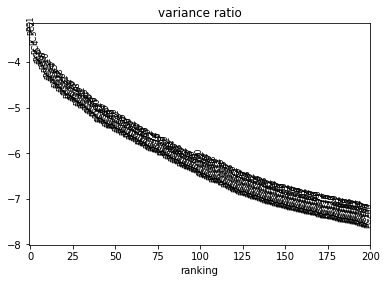

In [27]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=200)


In [28]:
sc.pp.neighbors(adata, n_neighbors=500, n_pcs=200)

In [29]:
sc.tl.umap(adata)

In [30]:
sc.tl.leiden(adata, resolution=0.25)

KeyboardInterrupt: 

In [31]:
adata

AnnData object with n_obs × n_vars = 62130 × 4096 
    obs: 0
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

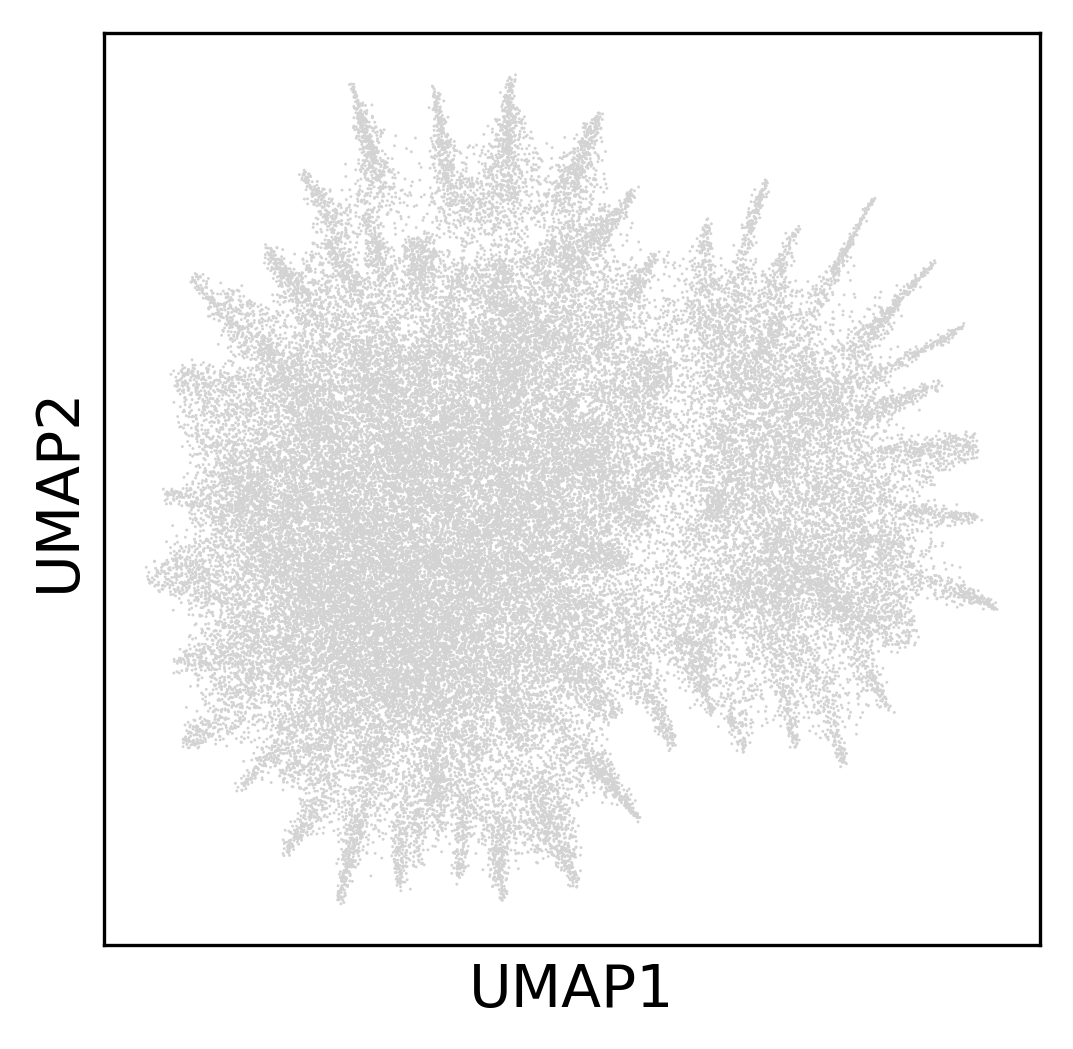

In [32]:
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.pl.umap(adata)
#sc.pl.umap(adata,color=['leiden'], use_raw=False)

In [38]:
pca_100 = PCA(n_components=500, svd_solver='randomized')
pca_result_100 = pca_100.fit_transform(adata.X)
print('Cumulative explained variation for 20 principal components: {}'.format(np.sum(pca_100.explained_variance_ratio_)))

Cumulative explained variation for 20 principal components: 0.8298012018203735
